In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import xarray as xr
import subprocess

In [2]:
cru_url = "https://iridl.ldeo.columbia.edu/SOURCES/.UEA/.CRU/.TS4p05/.monthly/.pre/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cru_path = 'download/cru_precip.nc'

print(cru_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cru_url, '-o', cru_path])

cru_1x1 = xr.open_dataset(cru_path, decode_times=True)
#change datetime to 01-MM  -YYYY
new_dates = pd.to_datetime(cru_1x1['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cru_1x1['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
cru_1x1= cru_1x1/30
#select 1981-2020
cru_1x1 = cru_1x1.sel(T=slice('1981-01-01', '2020-12-31'))




https://iridl.ldeo.columbia.edu/SOURCES/.UEA/.CRU/.TS4p05/.monthly/.pre/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [3]:
# cru1 = xr.open_dataset('data/cru_ts4.09.1981.1990.pre.dat.nc', decode_times=True)
# cru2 = xr.open_dataset('data/cru_ts4.09.1991.2000.pre.dat.nc', decode_times=True)
# cru3 = xr.open_dataset('data/cru_ts4.09.2001.2010.pre.dat.nc', decode_times=True)
# cru4 = xr.open_dataset('data/cru_ts4.09.2011.2020.pre.dat.nc', decode_times=True)

# cru = xr.concat([cru1, cru2, cru3, cru4], dim='time')
# cru = cru.rename({'time':'T', 'pre':'pre', 'lat':'Y', 'lon':'X'})
# #select arabian peninsula
# #cru = cru.sel(X=slice(32, 60), Y=slice(12, 37))
# #regrid to 1x1 degree
# cru = cru.interp(X=cru_1x1['X'], Y=cru_1x1['Y'])
# cru = cru/30

cru = cru_1x1

In [4]:
#create variable that is the rolling sum of the next 3 months
cru['rolling_sum'] = cru['pre'] + cru['pre'].shift(T=1) + cru['pre'].shift(T=2)
#cru = cru.dropna(dim='T')
#remove first two months with NaN values
cru = cru.isel(T=slice(2, None))


In [5]:
cru

<xarray.Dataset> Size: 3MB
Dimensions:      (Y: 26, X: 29, T: 478)
Coordinates:
  * Y            (Y) float32 104B 12.0 13.0 14.0 15.0 ... 34.0 35.0 36.0 37.0
  * X            (X) float32 116B 32.0 33.0 34.0 35.0 ... 57.0 58.0 59.0 60.0
  * T            (T) datetime64[ns] 4kB 1981-03-01 1981-04-01 ... 2020-12-01
Data variables:
    pre          (T, Y, X) float32 1MB 0.05917 0.04167 0.0525 ... 0.8258 0.7433
    rolling_sum  (T, Y, X) float32 1MB 0.05917 0.04167 0.0525 ... 1.544 1.241

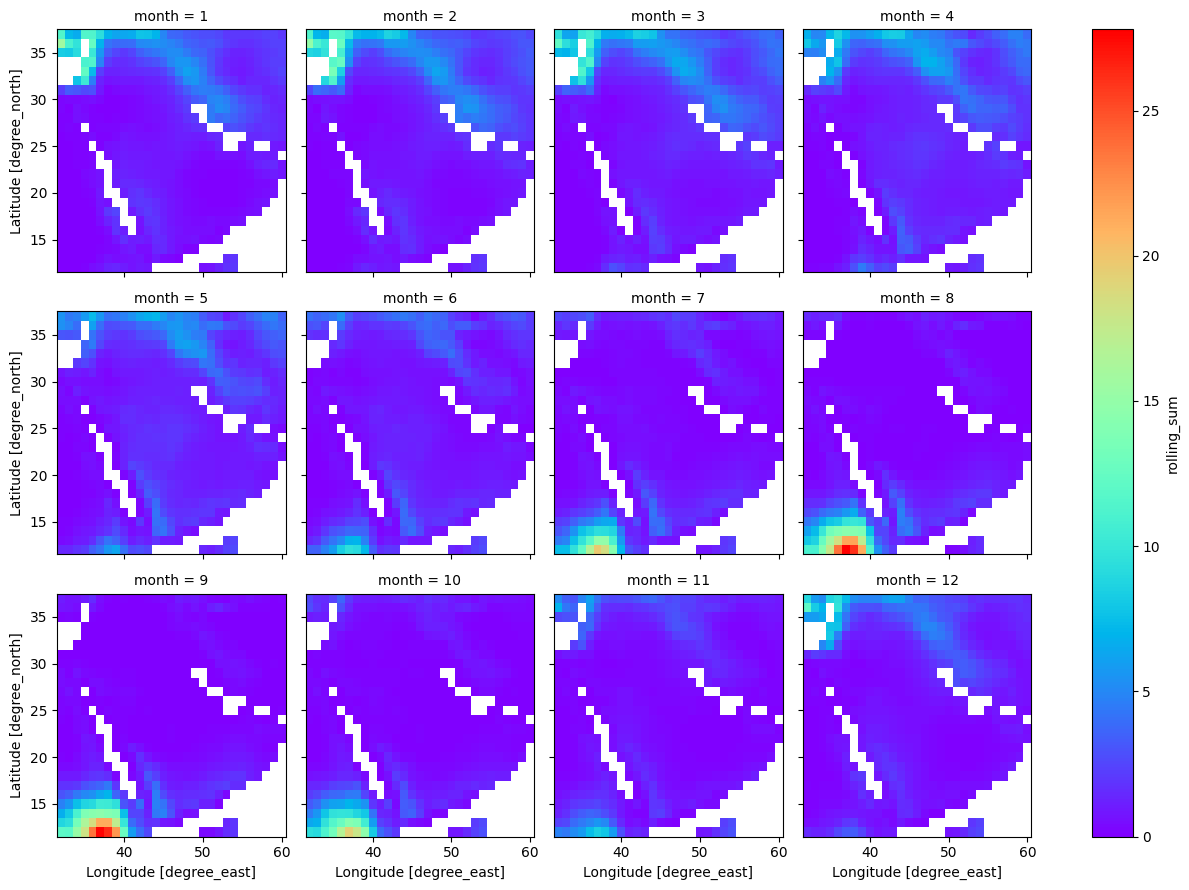

In [6]:
#plot monthly mean precip 
cru_monthly = cru['rolling_sum'].groupby('T.month').mean('T')
cru_monthly.plot(col='month', col_wrap=4, cmap='rainbow')

In [7]:
x_range = cru['rolling_sum'].X.values
y_range = cru['rolling_sum'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    #3month window modulo 12
    # months = [(month - i) % 12 if (month - i) % 12 != 0 else 12 for i in range(3)]
    data_month = cru['rolling_sum'].sel(T=cru['T.month']==month)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue

            data_grid_climo = data_grid.sel(T=slice('1991-01-01', '2020-12-01'))

            #check if 10% of the values are < 1
            if ((data_grid_climo.values < 1/30).sum() / data_grid_climo.size) > 0.1:
                continue
            else:
                # Fit pearson type III distribution to the data
                #try:
                a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                    # Calculate the CDF of the Pearson Type III distribution
                cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
                q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
                cdf_values = (cdf_values*(1-q)) + q
                    #replace 0 with 1e-6
                cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                    #replace 1 with 1-1e-6
                cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
            
                    # Convert CDF to SPI using the inverse normal distribution (PPF)
                spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)
                #except (ValueError, RuntimeError) as e:
                    # If fitting fails, leave Nans in the SPI values
                 #   continue
    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T': data_month['T'], 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


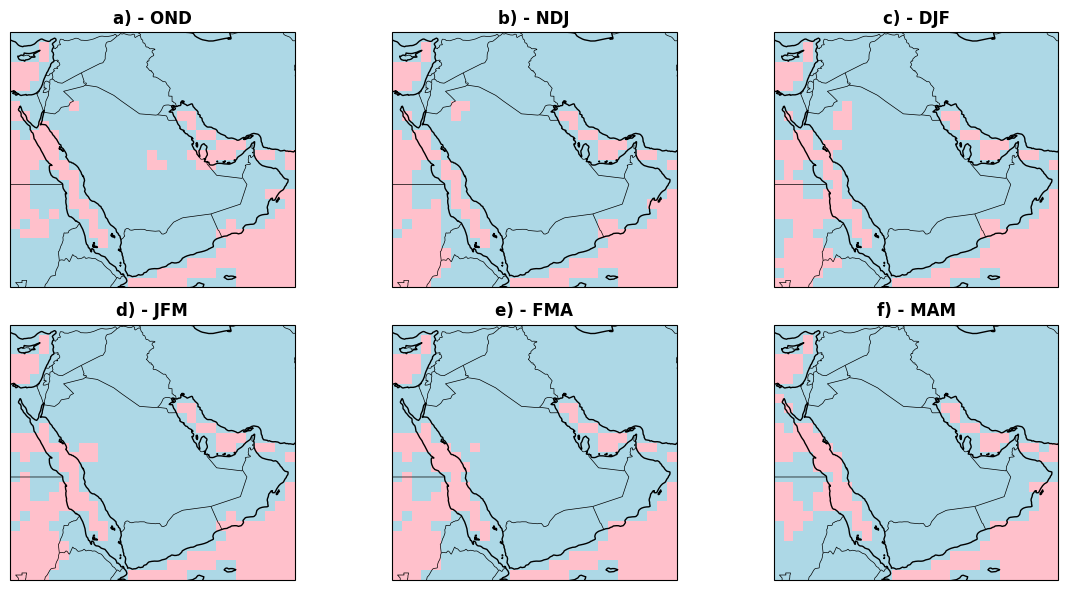

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Calculate monthly mean SPI
spi_monthly_means = spi.groupby('T.month').mean(dim='T')

# Turn into boolean 1 if not NaN, 0 if NaN
spi_monthly_means = spi_monthly_means.notnull().astype(int)

# Define the subset of seasons
month_indices = [12, 1, 2, 3, 4, 5]  # OND (12), NDJ (1), DJF (2), JFM (3), FMA (4), MAM (5)
season_labels = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']

# Custom colormap: 1 = valid (gray), 0 = NaN (pink)
# Make ocean white by plotting land only
cmap = mcolors.ListedColormap(["pink", "lightblue"])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create faceted plot
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2, 3,  # 2 rows, 3 columns for 6 seasons
    subplot_kw={'projection': proj},
    figsize=(12, 6)
)
axes = axes.flatten()

for i, (month, label) in enumerate(zip(month_indices, season_labels)):
    ax = axes[i]
    #letter a) for 0 subplot, b) for 1 subplot, etc.
    letter = chr(97 + i)

    # Add features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="none")   # keeps land transparent
    ax.add_feature(cfeature.OCEAN, facecolor="white") # ocean in white

    # Plot data
    spi_monthly_means.sel(month=month).plot(
        ax=ax,
        transform=proj,
        cmap=cmap,
        norm=norm,
        add_colorbar=False
    )
    ax.set_title(f"{letter}) - {label}", fontsize=12, fontweight='bold')

# Adjust layout
fig.tight_layout()
plt.savefig('figures/SPI3_CRU_mask.pdf', dpi=150)
plt.show()

In [9]:
save = True
if save:
    spi.to_netcdf('data/spi3_cru.nc')

# ERA5

In [10]:
era5 = xr.open_dataset('data/era5.nc', decode_times=False)
#time is YYYMMDD change ot datetime
# Convert to pandas datetime using the correct format
date_times = pd.to_datetime(era5.date.values.astype(str), format='%Y%m%d')
# Assign the datetime values back to the DataArray if needed
era5 = era5.swap_dims({'date':'T', 'longitude':'X', 'latitude':'Y'})
era5 = era5.assign_coords(T=date_times, X = era5.longitude, Y = era5.latitude)
#remove coordinate date
era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])


era5 = era5.sel(T=slice('1981-01-01', '2020-12-31'))
#convert to mm/day
era5['tp'] = era5['tp']*1000

era5['tp3m'] = era5['tp'] + era5['tp'].shift(T=1) + era5['tp'].shift(T=2)

#regrid to 1x1
era5 = era5.isel(T=slice(2, None))
era5 = era5.interp(X=cru['X'], Y=cru['Y'])



C:\Users\emile\AppData\Local\Temp\ipykernel_12796\3048030183.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])


In [11]:
era5

<xarray.Dataset> Size: 6MB
Dimensions:  (T: 478, Y: 26, X: 29)
Coordinates:
  * T        (T) datetime64[ns] 4kB 1981-03-01 1981-04-01 ... 2020-12-01
  * X        (X) float32 116B 32.0 33.0 34.0 35.0 36.0 ... 57.0 58.0 59.0 60.0
  * Y        (Y) float32 104B 12.0 13.0 14.0 15.0 16.0 ... 34.0 35.0 36.0 37.0
Data variables:
    tp       (T, Y, X) float64 3MB 0.515 0.3281 0.3967 ... 0.8068 0.8965 1.261
    tp3m     (T, Y, X) float64 3MB 0.515 0.3281 0.3967 ... 1.804 1.934 2.275
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T14:59 GRIB to CDM+CF via cfgrib-0.9.1...

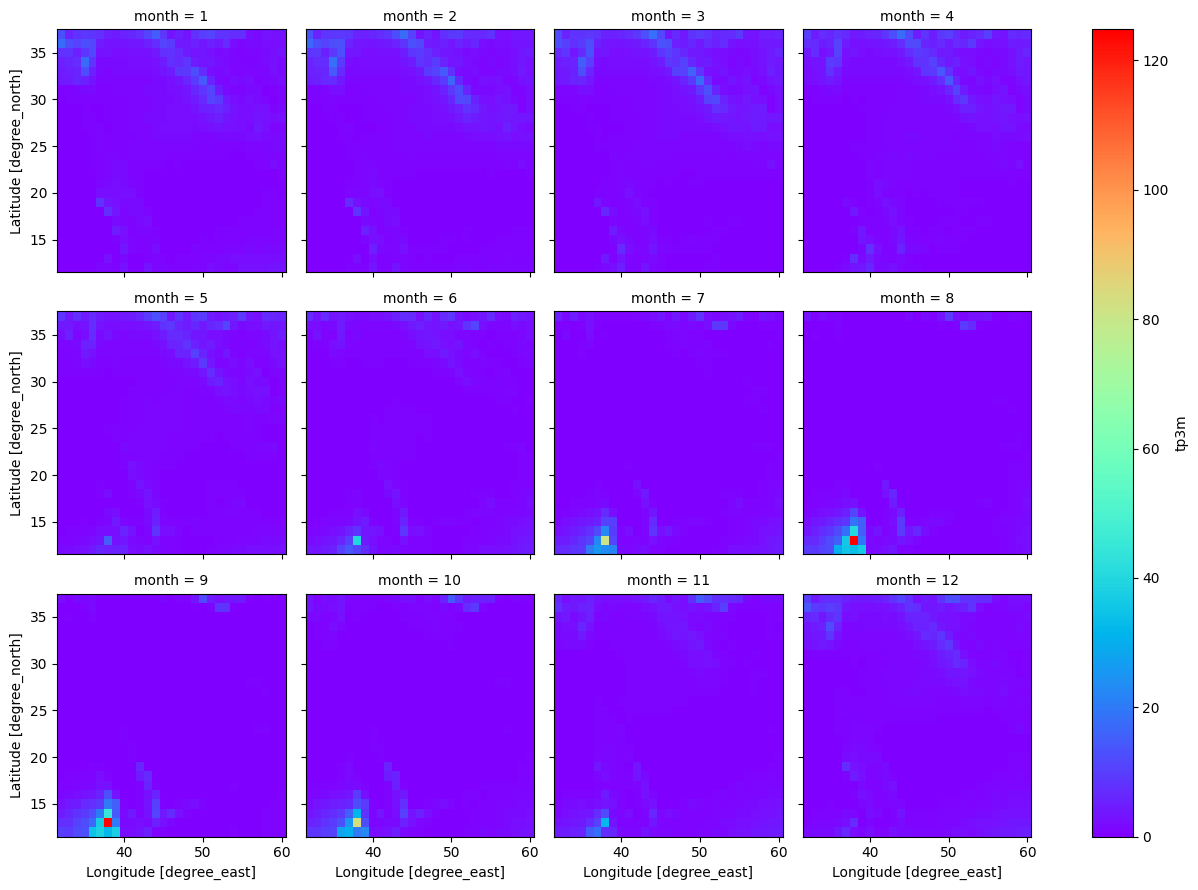

In [12]:
#plot monthly mean precip 
era5_monthly = era5['tp3m'].groupby('T.month').mean('T')
era5_monthly.plot(col='month', col_wrap=4, cmap='rainbow')


In [13]:
x_range = era5['tp3m'].X.values
y_range = era5['tp3m'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    #3month window modulo 12
    # months = [(month - i) % 12 if (month - i) % 12 != 0 else 12 for i in range(3)]
    data_month = era5['tp3m'].sel(T=era5['T.month']==month)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue

            data_grid_climo = data_grid.sel(T=slice('1991-01-01', '2020-12-01'))

            #check if 10% of the values are < 1
            if ((data_grid_climo.values < 1/30).sum() / data_grid_climo.size) > 0.1:
                continue
            else:
                # Fit pearson type III distribution to the data
                #try:
                a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                    # Calculate the CDF of the Pearson Type III distribution
                cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
                q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
                cdf_values = (cdf_values*(1-q)) + q
                    #replace 0 with 1e-6
                cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                    #replace 1 with 1-1e-6
                cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
            
                    # Convert CDF to SPI using the inverse normal distribution (PPF)
                spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)
                #except (ValueError, RuntimeError) as e:
                    # If fitting fails, leave Nans in the SPI values
                 #   continue
    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T': data_month['T'], 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


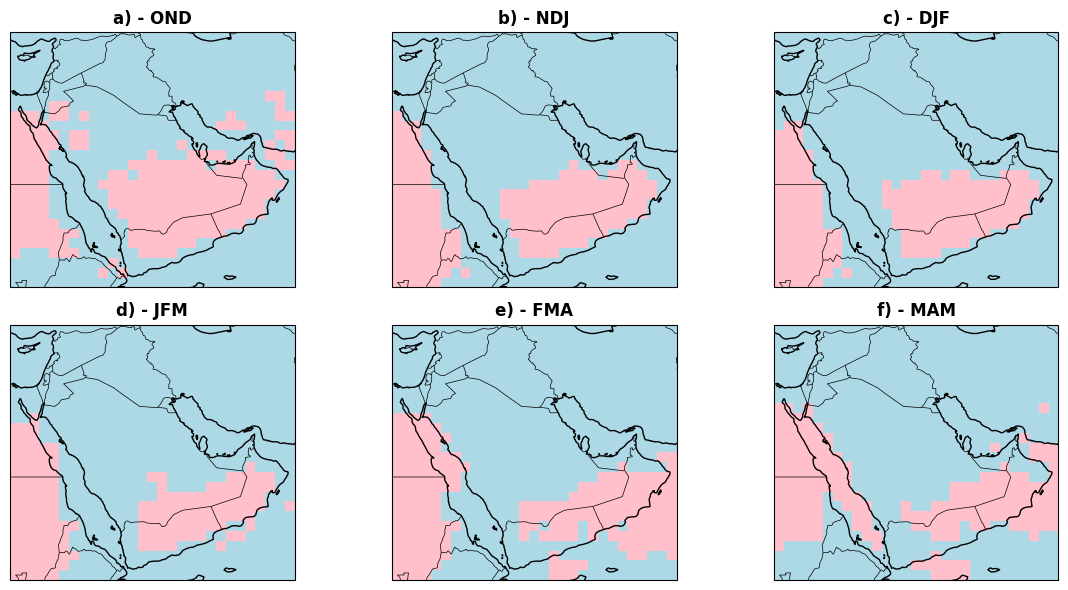

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Calculate monthly mean SPI
spi_monthly_means = spi.groupby('T.month').mean(dim='T')

# Turn into boolean 1 if not NaN, 0 if NaN
spi_monthly_means = spi_monthly_means.notnull().astype(int)

# Define the subset of seasons
month_indices = [12, 1, 2, 3, 4, 5]  # OND (12), NDJ (1), DJF (2), JFM (3), FMA (4), MAM (5)
season_labels = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']

# Custom colormap: 1 = valid (gray), 0 = NaN (pink)
# Make ocean white by plotting land only
cmap = mcolors.ListedColormap(["pink", "lightblue"])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create faceted plot
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2, 3,  # 2 rows, 3 columns for 6 seasons
    subplot_kw={'projection': proj},
    figsize=(12, 6)
)
axes = axes.flatten()

for i, (month, label) in enumerate(zip(month_indices, season_labels)):
    ax = axes[i]
    #letter a) for 0 subplot, b) for 1 subplot, etc.
    letter = chr(97 + i)

    # Add features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="none")   # keeps land transparent
    ax.add_feature(cfeature.OCEAN, facecolor="white") # ocean in white

    # Plot data
    spi_monthly_means.sel(month=month).plot(
        ax=ax,
        transform=proj,
        cmap=cmap,
        norm=norm,
        add_colorbar=False
    )
    ax.set_title(f"{letter}) - {label}", fontsize=12, fontweight='bold')

# Adjust layout
fig.tight_layout()
plt.savefig('figures/SPI3_ERA5_mask.pdf', dpi=150)
plt.show()

In [15]:
save = True
if save:
    spi.to_netcdf('data/spi3_era5.nc')